In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio
import os
import time

from tqdm import tqdm

import sys
sys.path.append("../")
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

import sys
sys.path.append("../")
from pyfiles.dataset import Parallelo2oVCMelDataset
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import numpy as np
import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

from torch.utils.data import Dataset
class ParallelArcticDataset(Dataset):
    def __init__(self, src_dir, trg_dir, datasplit, scaler, mode="train", input_output=["mel", "wavlm"]):
        modefiles = datasplit[["train", "valid", "test"].index(mode)]
        filenames = [os.path.basename(a)[:-4] for a in glob.glob(src_dir+f"{input_output[0]}/*")]
        filenames.sort()
        files = []
        for fn in filenames:
            if fn in modefiles:
                exist = True
                if not(os.path.exists(f"{trg_dir}{input_output[1]}/{fn}.npy")):
                    exist = False
                    break
                if exist:
                    files += [fn]
        data = {}
        data["src"] = [src_dir + f"{input_output[0]}/{fn}.npy" for fn in files]
        data["trg"] = [trg_dir + f"{input_output[1]}/{fn}.npy" for fn in files]
            
        self.data = data
        self.scaler = scaler
        self.files = files
        self.input_output = input_output
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        items = {}
        src_mel = self.data["src"][idx]
        trg_mel = self.data["trg"][idx]
        items["src_feat"] = self.scaler[self.input_output[0]].transform(np.load(src_mel).T)
        items["trg_feat"] = self.scaler[self.input_output[1]].transform(np.load(trg_mel).T)
        items["src_condition"] = np.load(src_mel.replace("mel", "accent_embedding"))
        items["trg_condition"] = np.load(trg_mel.replace("mel", "accent_embedding"))
        items["utt_id"] = self.files[idx]
        items["accent_id"] = 0
        
        return items

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
# Dataset Variables
src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"

scaler = {}
scaler_filename = f"ckpts/scalers/LibriTTS-R_16000.save"
scaler["mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_wavlm.save"
scaler["wavlm"] = joblib.load(scaler_filename)

In [3]:
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/nocondition_accentaddition_gt2syn_melmel_smaller/checkpoint-240000steps.pkl"
checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/nocondition_accentaddition_gt2syn_melmel_small/checkpoint-300000steps.pkl"

if "smaller" in checkpoint_path:
    size = "smaller"
elif "small" in checkpoint_path:
    size = "small"
else:
    size = ""

args = {}
args["rank"] = 0
args["checkpoint"] = checkpoint_path
args["outdir"] = os.path.dirname(args["checkpoint"]) + "/"
args["config_path"] = f"./../egs/l2-arctic/cascade/conf/{size}m2mvtn.melmel.yaml"
args["init_checkpoint"] = ""
args["resume"] = ""
args["distributed"] = False
args = Dict2Obj(args)

# load main config
with open(args.config_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config.update(vars(args))

In [4]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(args.rank)
    
### Dataset Preparation ###
dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "test", input_output=["mel", "mel"])

### Model Preparation ###
model_class = getattr(seq2seq_vc.models, config["model_type"])
model = model_class(**config["model_params"])
model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
model = model.eval().to(device)
    
### Vocoder Preparation ###
data_dir = "/mntcephfs/lab_data/shoinoue/"
# fs = 24000
fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
vocoder = get_vocos(config_path, model_path, fs)

In [5]:
with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
    for idx, batch in enumerate(pbar, 1):
        start_time = time.time()
        utt_id = os.path.basename(dataset.files[idx-1]).split(".")[0]
        x = batch["src_feat"]
        x = torch.tensor(x, dtype=torch.float).to(device)
        gt = batch["trg_feat"]
        gt = torch.tensor(gt, dtype=torch.float).to(device)
        xembs = torch.tensor(batch["src_condition"].reshape(1, -1), dtype=torch.float).to(device)
        yembs = torch.tensor(batch["trg_condition"].reshape(1, -1), dtype=torch.float).to(device)
        config_inference = config["inference"].copy()
        config_inference["maxlenratio"] = config_inference["maxlenratio"]*gt.shape[0]/x.shape[0]
        outs, probs, att_ws = model.inference(
            x, config_inference, xembs, yembs, spemb=None
        )

        # plot figures
        plot_generated_and_ref_2d(
            outs.cpu().numpy(),
            config["outdir"] + f"/outs/{utt_id}.png",
            origin="lower",
        )
        
        plot_1d(
            probs.cpu().numpy(),
            config["outdir"] + f"/probs/{utt_id}_prob.png",
        )
        plot_attention(
            att_ws.cpu().numpy(),
            config["outdir"] + f"/att_ws/{utt_id}_att_ws.png",
        )
        
        ### Waveform ###
        if not os.path.exists(os.path.join(config["outdir"], "wav")):
            os.makedirs(os.path.join(config["outdir"], "wav"), exist_ok=True)
        denormalized_mel = scaler["mel"].inverse_transform(cuda2numpy(outs))
        y = vocoder.decode(torch.tensor(denormalized_mel.T).unsqueeze(0))
        sf.write(
            os.path.join(config["outdir"], "wav", f"{utt_id}.wav"),
            y.cpu().numpy()[0],
            fs,
            "PCM_16",
        )
        
        ### Mel ###
        if not os.path.exists(os.path.join(config["outdir"], "mel")):
            os.makedirs(os.path.join(config["outdir"], "mel"), exist_ok=True)
            
        denormalized_input_mel = scaler["mel"].inverse_transform(x.cpu().numpy())
        denormalized_gt_mel = scaler["mel"].inverse_transform(gt.cpu().numpy())
        np.save(os.path.join(config["outdir"], "mel", f"output_{utt_id}.npy"), denormalized_mel)
        np.save(os.path.join(config["outdir"], "mel", f"gt_{utt_id}.npy"), denormalized_gt_mel)
        np.save(os.path.join(config["outdir"], "mel", f"input_{utt_id}.npy"), denormalized_input_mel)
        if idx>0:
            break

[decode]:   0%|          | 0/100 [00:04<?, ?it/s]


# Check the result

source


ground truth


predicted


<AxesSubplot: title={'center': 'reconstructed (mel)'}>

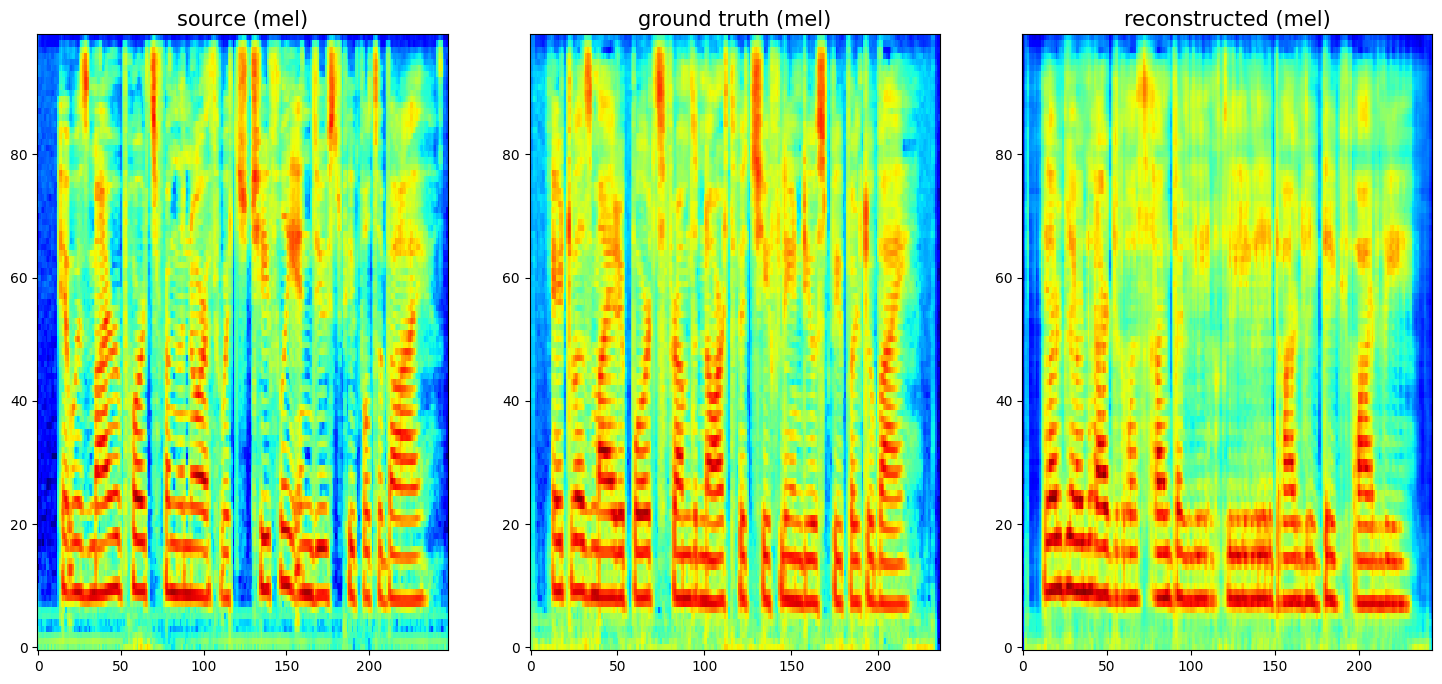

In [6]:
utt_id = dataset.files[0]
utt_basename = utt_id
data = dataset[dataset.files.index(utt_id)]

imelpath = os.path.join(config["outdir"], "mel", f"input_{utt_basename}.npy")
omelpath = os.path.join(config["outdir"], "mel", f"output_{utt_basename}.npy")
gtmelpath = os.path.join(config["outdir"], "mel", f"gt_{utt_basename}.npy")
wavpath = os.path.join(config["outdir"], "wav", f"{utt_basename}.wav")
predmel = np.load(omelpath)
predwav, sr = torchaudio.load(wavpath)

gtmel = np.load(gtmelpath)
gtwav = vocoder.decode(torch.tensor(gtmel.T).unsqueeze(0))
sourcemel = np.load(imelpath)
sourcewav = vocoder.decode(torch.tensor(sourcemel.T).unsqueeze(0))

%matplotlib inline  
fig = plt.figure(figsize=(18, 8))
print("source")
play_audio(sourcewav, fs)
print("ground truth")
play_audio(gtwav, fs)
print("predicted")
play_audio(predwav, sr)

plot_spectrogram(sourcemel.T, fig, (1,3,1), title=f"source (mel)")
plot_spectrogram(gtmel.T, fig, (1,3,2), title="ground truth (mel)")
plot_spectrogram(predmel.T, fig, (1,3,3), title="reconstructed (mel)")